# Cookie Consent Management Solution Test
#### This notebook demonstrates the complete flow of checking cookie consent management on websites.

## Import required components

In [13]:
from url_processor import URLProcessor
from provider_registry import ProviderRegistry
from browser_manager import BrowserManager
from data_collection import DataCollectionService
import json
from dataclasses import asdict
# Import necessary libraries
import networkx as nx
from urllib.parse import urlparse
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

## Initialize components

In [14]:
url_processor = URLProcessor()
provider_registry = ProviderRegistry()
browser_manager = BrowserManager(provider_registry)
data_collector = DataCollectionService(browser_manager)
print("All components initialized")

All components initialized


## Get URLs from user

In [15]:
"""
print("Choose URL input method:")
print("1. Enter comma-separated URLs")
print("2. Use default Abbott URLs")
choice = input("Enter choice (1 or 2): ")

if choice == "1":
   urls_input = input("Enter URLs (comma-separated): ")
   test_urls = [url.strip() for url in urls_input.split(",")]
else:
   test_urls = [
       "it.pediasure.abbott",
       "it.ensure.abbott", 
       "es.ensure.abbott",
       "es.pediasure.abbott"
   ]

# Process URLs to ensure proper format
formatted_urls = []
for url in test_urls:
   if not url.startswith(('http://', 'https://')):
       url = 'https://' + url
   formatted_urls.append(url)

print(f"\nProcessing {len(formatted_urls)} URLs:")
for url in formatted_urls:
   print(f"- {url}")
"""

'\nprint("Choose URL input method:")\nprint("1. Enter comma-separated URLs")\nprint("2. Use default Abbott URLs")\nchoice = input("Enter choice (1 or 2): ")\n\nif choice == "1":\n   urls_input = input("Enter URLs (comma-separated): ")\n   test_urls = [url.strip() for url in urls_input.split(",")]\nelse:\n   test_urls = [\n       "it.pediasure.abbott",\n       "it.ensure.abbott", \n       "es.ensure.abbott",\n       "es.pediasure.abbott"\n   ]\n\n# Process URLs to ensure proper format\nformatted_urls = []\nfor url in test_urls:\n   if not url.startswith((\'http://\', \'https://\')):\n       url = \'https://\' + url\n   formatted_urls.append(url)\n\nprint(f"\nProcessing {len(formatted_urls)} URLs:")\nfor url in formatted_urls:\n   print(f"- {url}")\n'

## Ensure URL format is correct

In [16]:
test_urls = ['it.pediasure.abbott']
formatted_urls = []
for url in test_urls:
   if not url.startswith(('http://', 'https://')):
       url = 'https://' + url
   formatted_urls.append(url)

print(f"\nProcessing {len(formatted_urls)} URLs:")
for url in formatted_urls:
   print(f"- {url}")


Processing 1 URLs:
- https://it.pediasure.abbott


## Process URLs

In [17]:
print("\nStarting URL processing...")
url_results = url_processor.process_urls(formatted_urls)
print(f"URL processing complete. {len(url_results)} results obtained")


Starting URL processing...
URL processing complete. 1 results obtained


## Collect consent data for each URL

In [18]:
all_results = []
for i, url_result in enumerate(url_results, 1):
    print("Processing URL")
    if url_result.is_valid:
        print("URL is valid, checking for cookie consent...")
        result = data_collector.create_result(url_result)
        all_results.append(result)
        print("Cookie consent check complete")
    else:
        print(f"Skipping invalid URL. Error: {url_result.error_message}")
    
print(f"Processed {len(all_results)} valid URLs")

Processing URL
URL is valid, checking for cookie consent...


Cookie consent check complete
Processed 1 valid URLs


## Display Results

In [19]:
# Display results
print("\nGenerating results...")
for i, result in enumerate(all_results, 1):
    print(f"\n=== Result {i}/{len(all_results)} ===")
    print(f"URL: {result.url_info['requested_url']}")
    
    #print("\nFull Result:")
    #print(json.dumps(asdict(result), indent=2))
    
    print("\nSummary:")
    summary = data_collector.generate_cod_results(result, include_network_chains=False)
    print(json.dumps(summary, indent=2))
    
    if result.errors:
        print("\nErrors encountered:")
        for error in result.errors:
            print(f"- {error}")


Generating results...

=== Result 1/1 ===
URL: https://it.pediasure.abbott

Summary:
{
  "url_info": {
    "requested_url": "https://it.pediasure.abbott",
    "final_url": "https://it.pediasure.abbott",
    "status_code": 200,
    "domain": "it.pediasure.abbott"
  },
  "ccm_banner": {
    "banner_found": true,
    "provider_name": "TrustArc"
  },
  "preConsent": {
    "pageNotInteractable": true,
    "pageScrollable": true,
    "noFirstPartyCookies": false,
    "noThirdPartyCookies": false,
    "noThirdPartyRequests": false
  },
  "postConsent": {
    "onAccept": {
      "noAdditionalFirstPartyCookies": false,
      "noAdditionalThirdPartyCookies": false,
      "noAdditionalThirdPartyRequests": false
    },
    "onReject": {
      "noAdditionalFirstPartyCookies": false,
      "noAdditionalThirdPartyCookies": false,
      "noAdditionalThirdPartyRequests": false
    }
  }
}


## Visualise

### Visualisation Functions

In [20]:
def normalize_url(url: str) -> str:
    """
    Normalizes URLs by removing 'http://', 'https://', and 'www.' prefixes.
    For example: 'https://www.example.com' becomes 'example.com'
    """
    # Remove http:// or https://
    if "://" in url:
        url = url.split("://", 1)[1]
    
    # Remove www.
    if url.startswith("www."):
        url = url[4:]
        
    return url

def shorten_url(url):
    """
    For example, 'https://abc.com/page/something' becomes 'abc.com/page'.
    """
    try:
        # First normalize the URL
        url = normalize_url(url)
        parsed = urlparse(f"http://{url}")  # Add scheme to make urlparse work correctly
        netloc = parsed.netloc
        # Process the path: strip leading/trailing slashes and split by '/'
        if parsed.path and parsed.path != "/":
            parts = parsed.path.strip("/").split("/")
            if parts:
                return f"{netloc}/{parts[0]}"
        return netloc
    except Exception:
        # In case of any parsing error, return the original URL.
        return url
    
def collapse_url(url: str, requested_url: str, max_path_sections: int = 2) -> str:
    """
    Collapses URLs, with special handling for the requested_url:
    - If URL starts with requested_url, return requested_url
    - Otherwise collapse normally
    """
    try:
        # Normalize both URLs before comparison
        normalized_url = normalize_url(url)
        normalized_requested = normalize_url(requested_url)
        
        # Check if this URL is or starts with the requested_url
        if normalized_url.startswith(normalized_requested):
            return requested_url
            
        parsed = urlparse(f"http://{normalized_url}")  # Add scheme to make urlparse work correctly
        netloc = parsed.netloc or "unknown"
        # Split path into segments, ignoring empty parts
        path_parts = [p for p in parsed.path.strip("/").split("/") if p]
        # Keep only up to 'max_path_sections' segments
        collapsed = "/".join(path_parts[:max_path_sections])
        return f"{netloc}/{collapsed}" if collapsed else netloc
    except Exception:
        return url

def get_node_color(short_label: str) -> str:
    """Assigns colors to nodes based on their domain."""
    lower_label = short_label.lower()
    
    # Mapping from keyword substring -> color
    keyword_to_color = {
        "facebook": "blue",
        "amazon": "orange",
        "tiktok": "black",
        "abbott": "royalblue",
        "hubspot": "orange",
        "hs-analytics": "orange",
        "google": "yellow",
        "googletagmanager": "yellow",
        "doubleclick": "yellow",
        "trustarc": "green",
    }
    
    # Return the first match or default to gray
    for keyword, color in keyword_to_color.items():
        if keyword in lower_label:
            return color
    return "gray"

def draw_network_graph(result, hierarchical=False, collapse=False, make_url_short=False, phase="Pre-consent"):
    # Convert the dataclass to a dictionary for dictionary-style access
    result_dict = asdict(result)
    requested_url = result_dict["url_info"]["requested_url"]

    # Extract the request chains
    if phase == "Post-consent; Cookies Rejected":
        chains = result_dict["reject_flow"]["network_state"]["request_chains"]
    elif phase == "Post-consent; Cookies Accepted":
        chains = result_dict["accept_flow"]["network_state"]["request_chains"]
    else:
        chains = result_dict["page_landing"]["state"]["network_state"]["request_chains"]

    # We will build a new directed graph that uses "collapsed" node labels
    G = nx.DiGraph()
    
    # A mapping from the collapsed node label -> set of raw URLs (to track how many)
    node_map = {}
    
    # Process chains and build the graph
    if collapse:
        # Collapse and build the graph
        for chain in chains:
            raw_src = chain.get("source", "unknown")
            raw_tgt = chain.get("target", "unknown")
            
            src = collapse_url(raw_src, requested_url, max_path_sections=2)
            tgt = collapse_url(raw_tgt, requested_url, max_path_sections=2)
            
            node_map.setdefault(src, set()).add(raw_src)
            node_map.setdefault(tgt, set()).add(raw_tgt)
            
            G.add_edge(src, tgt, type=chain.get("type", "unknown"))
    else:
        for chain in chains:
            src = chain.get("source", "unknown")
            tgt = chain.get("target", "unknown")
            
            # Even when not collapsing URLs, we still want to consolidate the requested_url
            if normalize_url(src).startswith(normalize_url(requested_url)):
                src = requested_url
            if normalize_url(tgt).startswith(normalize_url(requested_url)):
                tgt = requested_url
                
            # When not collapsing, each node represents exactly one URL
            node_map.setdefault(src, set()).add(src)
            node_map.setdefault(tgt, set()).add(tgt)
            G.add_edge(src, tgt, type=chain.get("type", "unknown"))
    
    # Find orphan nodes (nodes with no incoming edges except requested_url)
    all_nodes = set(G.nodes())
    nodes_with_incoming = {v for u, v in G.edges()}
    orphan_nodes = all_nodes - nodes_with_incoming - {requested_url}
    
    # Add edges from requested_url to orphan nodes
    for orphan in orphan_nodes:
        G.add_edge(requested_url, orphan, type="unknown")
    
    # Build labels and node colors
    labels = {}
    node_colors = []
    for node in G.nodes():
        raw_count = len(node_map[node])  # Distinct raw URLs
        if make_url_short:
            short_label = f"{shorten_url(node)} ({raw_count})"  # e.g. "abc.com/page (3)"
            labels[node] = short_label
        else:
            labels[node] = f"{node} ({raw_count})"
        color = get_node_color(node)
        node_colors.append(color)
    
    # Choose a layout
    if hierarchical:
        # Requires graphviz installed
        # rankdir=TB means top-to-bottom flow
        pos = graphviz_layout(G, prog='dot', args='-Grankdir=TB')
    else:
        # Default: force-directed layout
        pos = nx.spring_layout(G, seed=42)
    
    # Draw
    plt.figure(figsize=(24, 16))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray')
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    
    layout_name = "Hierarchical (Top-Down)" if hierarchical else "Spring"
    plt.title(f"Network Request Chains for {requested_url} - {phase} phase")
    plt.axis("off")
    plt.show()


### Visualise Pre-consent Phase


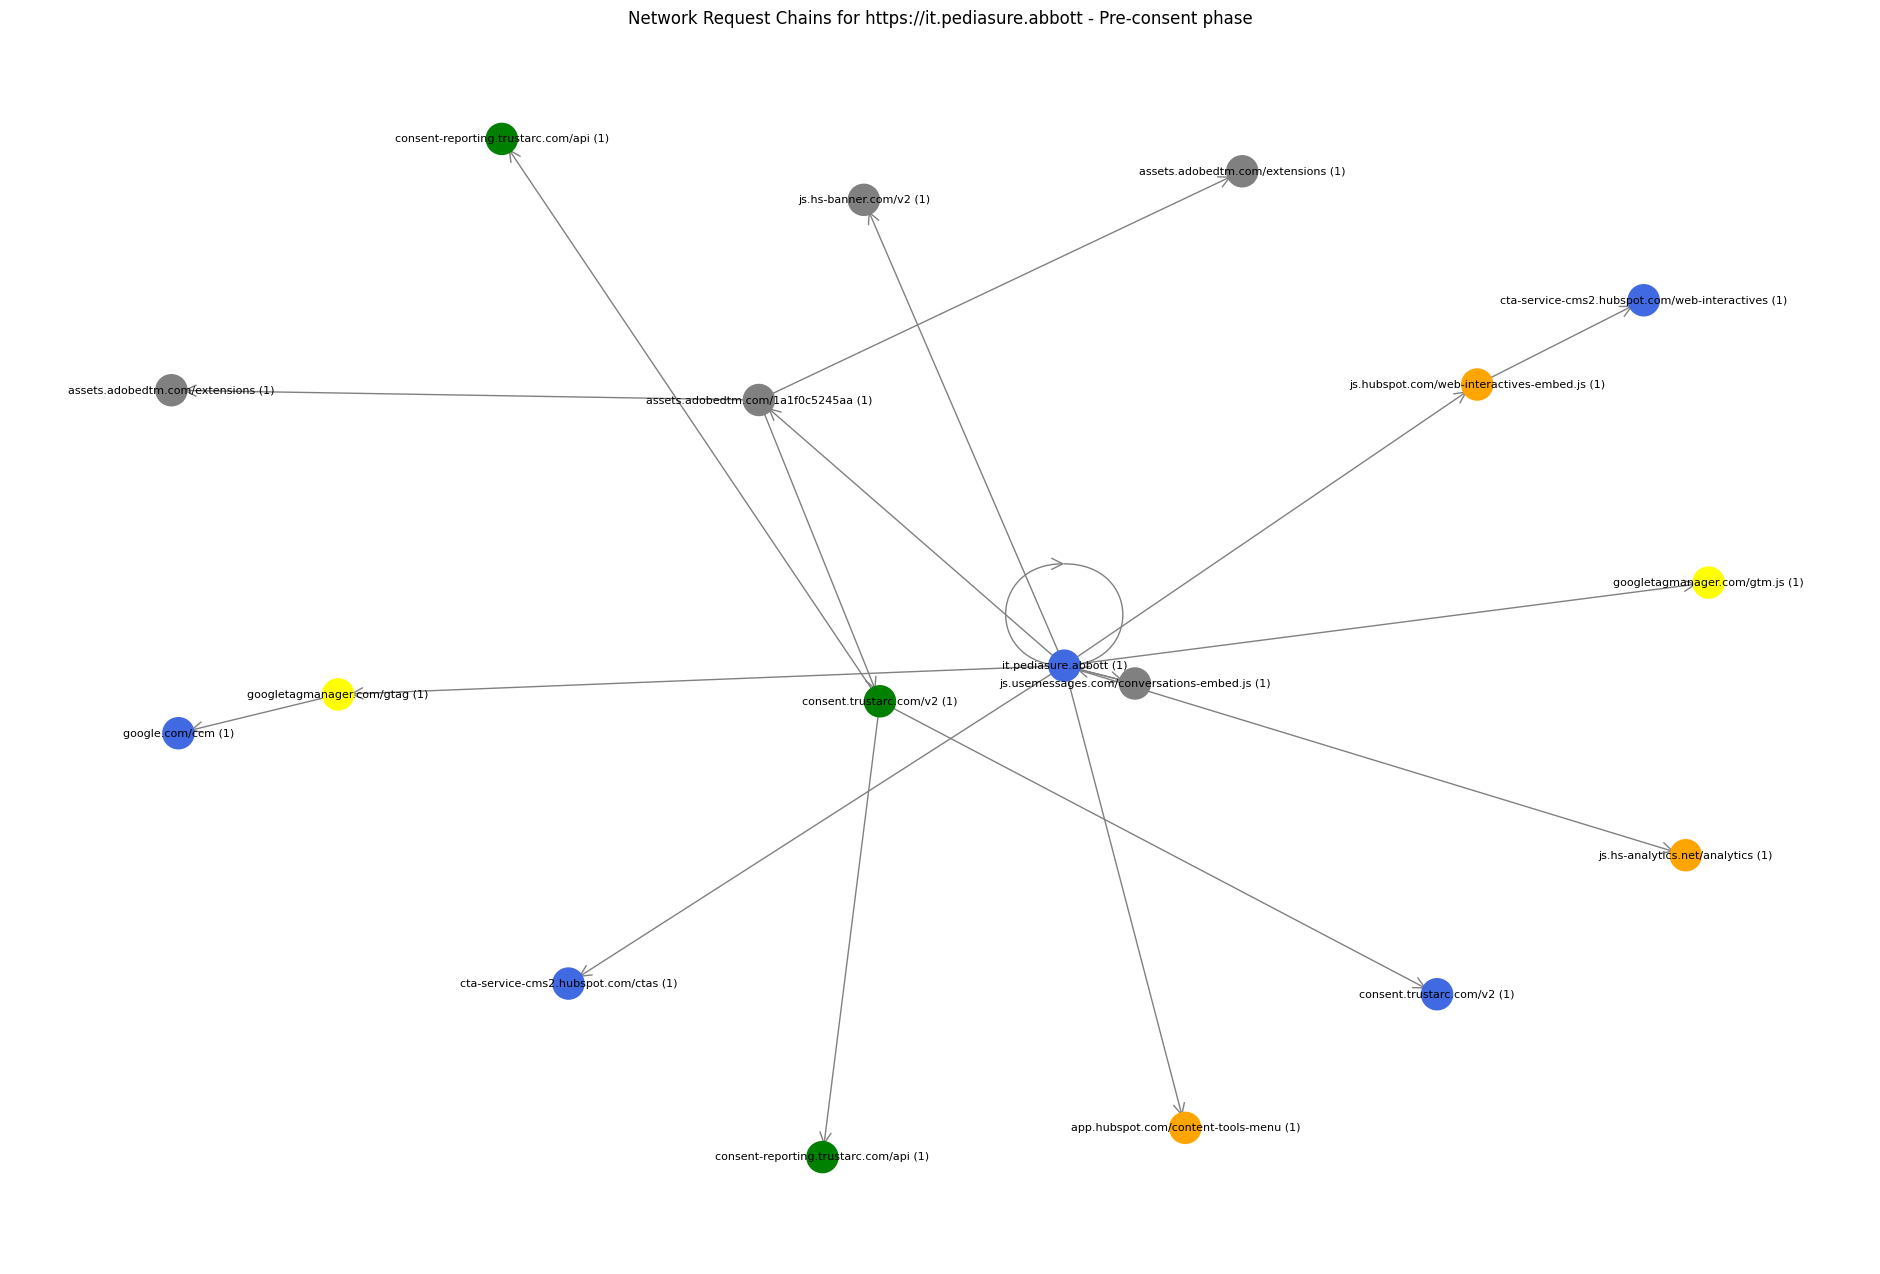

In [21]:
draw_network_graph(all_results[0], False, False, True, "Pre-consent")

### Visualise Post-consent On Accept Phase

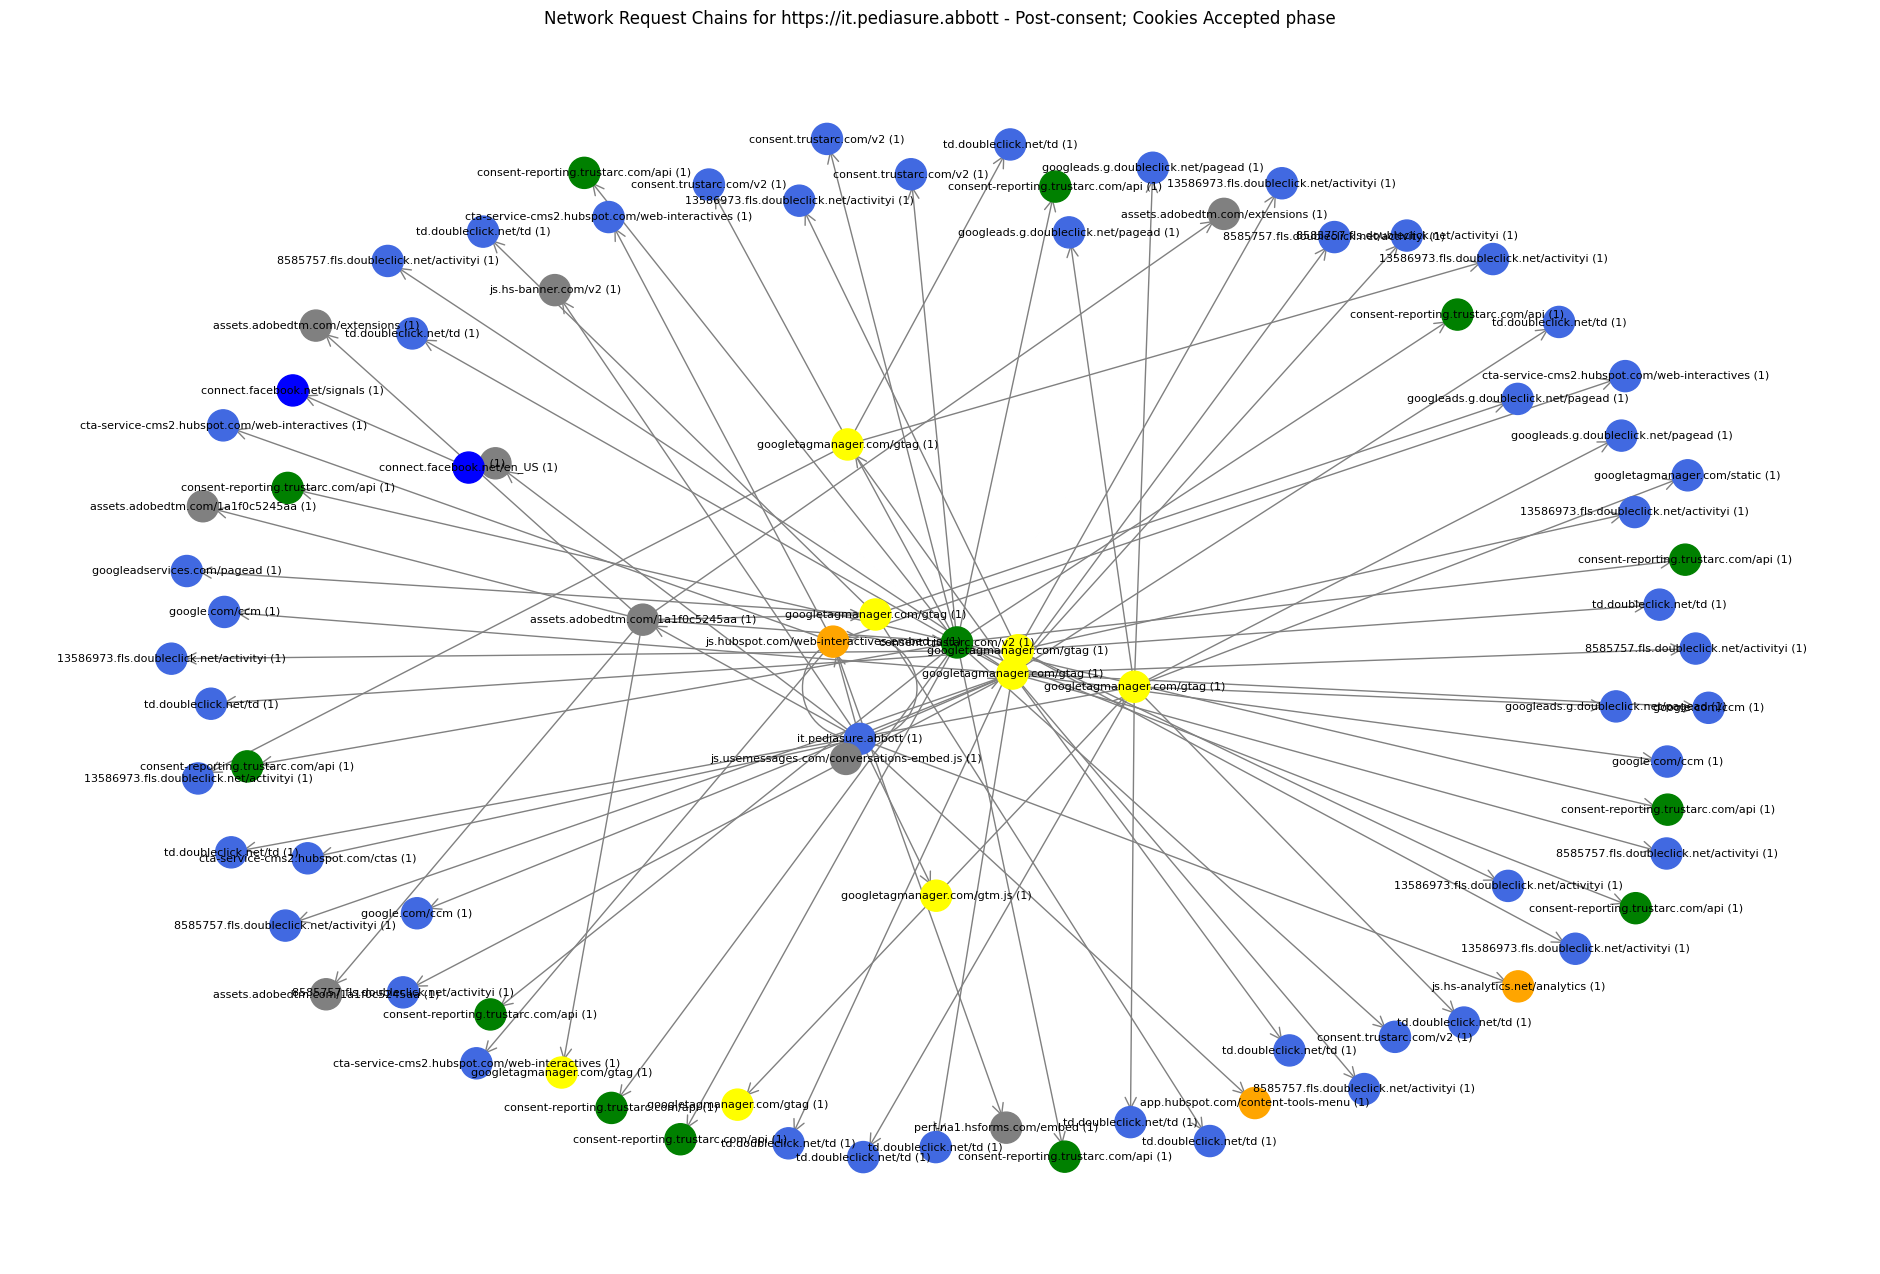

In [22]:
draw_network_graph(all_results[0], False, False, True, "Post-consent; Cookies Accepted")

### Visualise Post-consent On Reject Phase

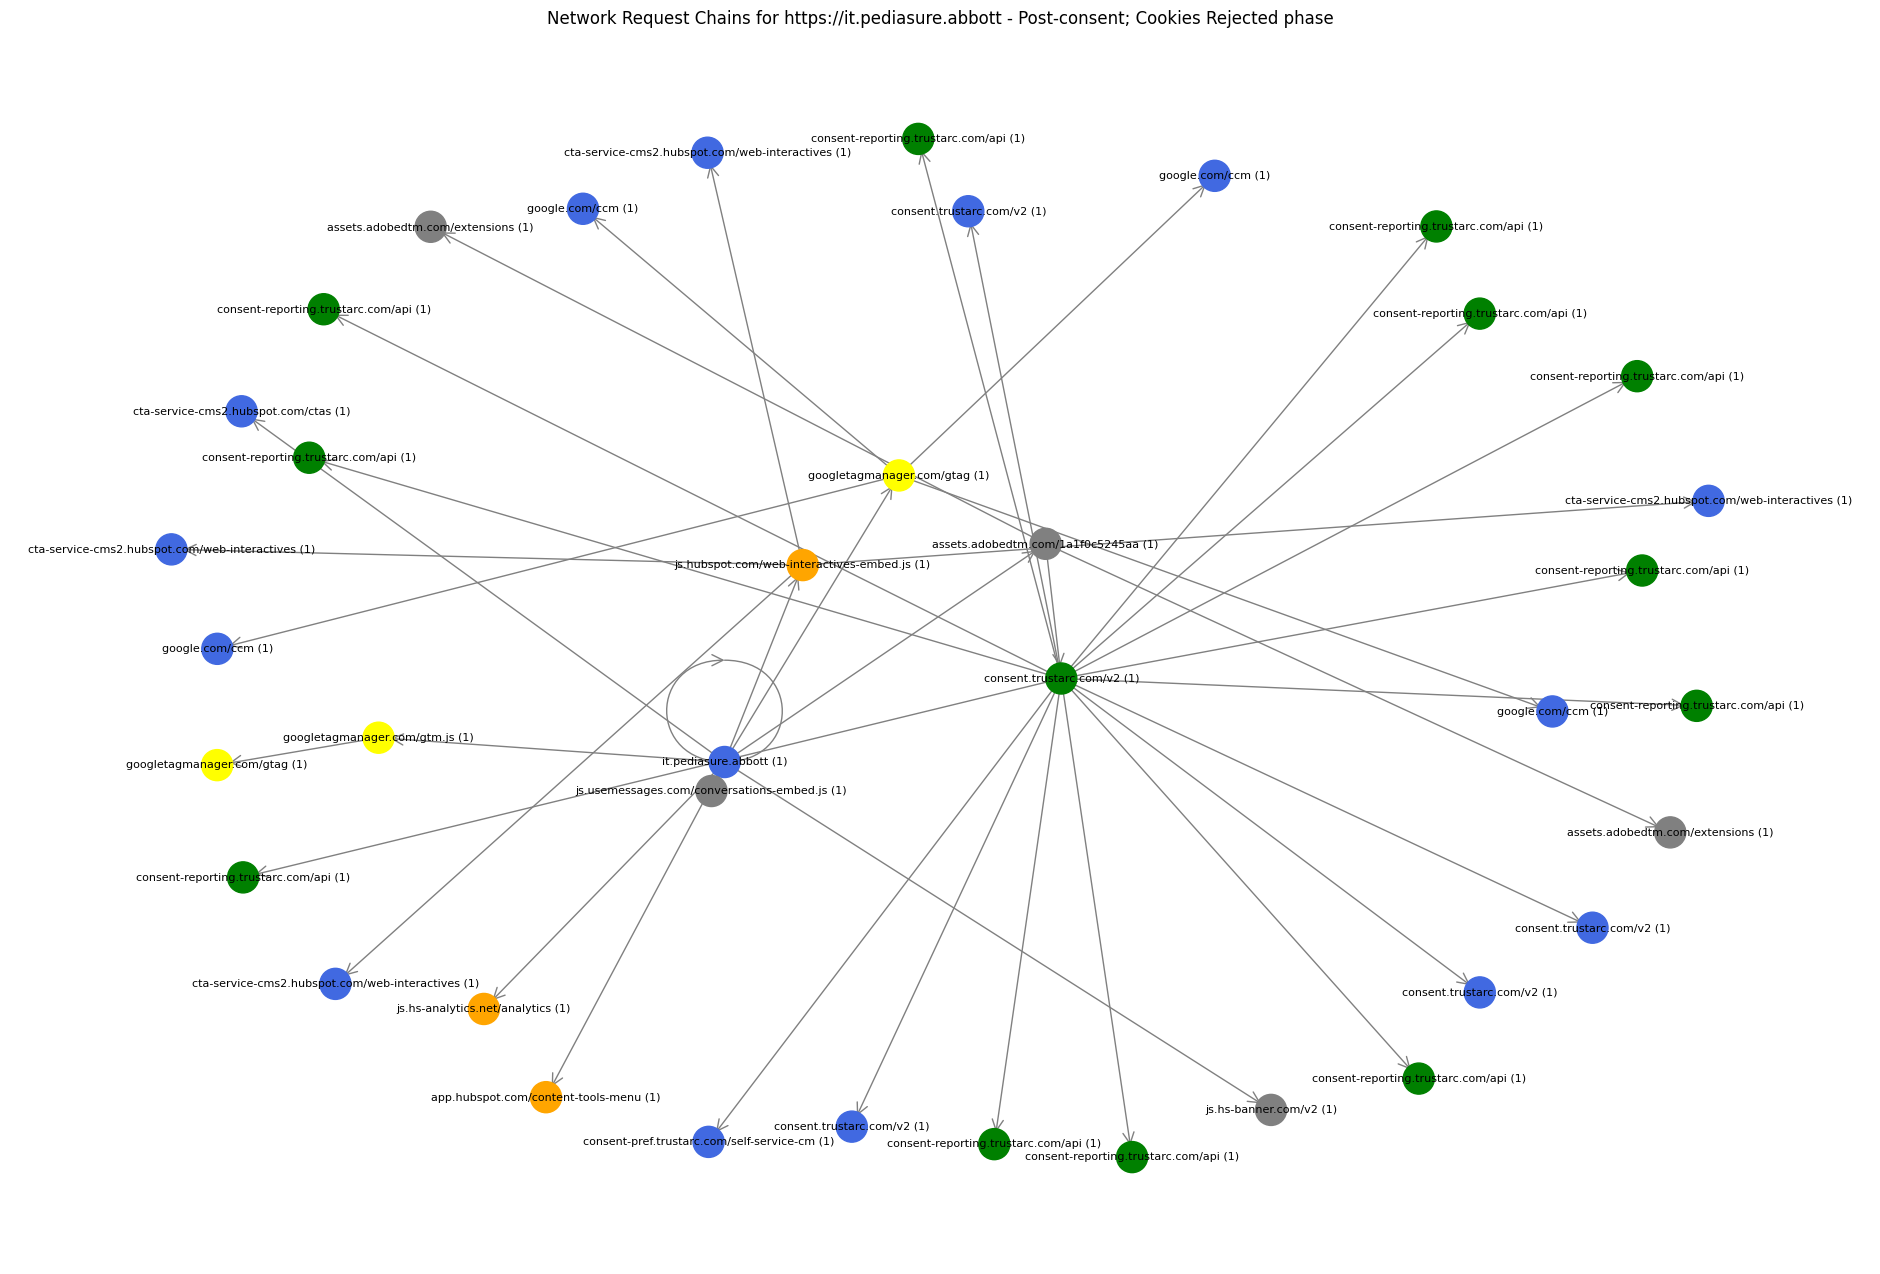

In [23]:
draw_network_graph(all_results[0], False, False, True, "Post-consent; Cookies Rejected")

## Cleanup

In [24]:
print("\nCleaning up resources...")
browser_manager.cleanup()
print("Cleanup complete")


Cleaning up resources...
Cleanup complete
